In [60]:
import numpy as np

def parse_metric_table(table_str):
    lines = table_str.strip().split('\n')
    data = {}
    current_key = None
    for line in lines:
        if ':' in line:
            key, val = line.split(':', 1)
            key = key.strip()
            val = val.strip()
            if val == '':
                current_key = key
                data[current_key] = []
            else:
                data[key] = [float(val)]
        elif current_key and '-' in line:
            val = line.strip('- ').strip()
            if val:
                data[current_key].append(float(val))
    return data

def aggregate_tables(metric_tables):
    combined_data = {}
    for table in metric_tables:
        data = parse_metric_table(table)
        for key, values in data.items():
            if key.endswith('_per_class'):  # Handle per-class separately
                if key not in combined_data:
                    combined_data[key] = [[] for _ in values]  # Create a list of lists
                for i, value in enumerate(values):
                    combined_data[key][i].append(value)
            else:
                if key in combined_data:
                    combined_data[key].extend(values)
                else:
                    combined_data[key] = values.copy()
    return combined_data

def calculate_statistics(data):
    result = {}
    for key, values in data.items():
        if isinstance(values[0], list):  # Handle per-class list of lists
            stats = []
            for val_list in values:
                mean_val = np.mean(val_list)
                std_val = np.std(val_list)
                stats.append((mean_val, std_val))
            result[key] = stats
        else:
            mean_val = np.mean(values)
            std_val = np.std(values)
            result[key] = (mean_val, std_val)
    return result

def process_metric_tables(metric_tables):
    combined_data = aggregate_tables(metric_tables)
    return calculate_statistics(combined_data)

def format_results_as_table(data):
    output_str = ""
    for key, values in data.items():
        if isinstance(values, list):
            output_str += f"{key}:\n"
            for value in values:
                mean_val, std_val = value
                output_str += f"    - ({mean_val:.3f}, {std_val:.3f})\n"
        else:
            mean_val, std_val = values
            output_str += f"{key}: ({mean_val:.3f}, {std_val:.3f})\n"
    return output_str

# Example usage with two tables
metric_tables = [
    """mAP_50-95: 0.59
mAP_50: 0.845
mAP_75: 0.671
mAP_per_class:
    - 0.419
    - 0.715
    - 0.635
f1_per_class:
    - 0.693
    - 0.884
    - 0.803
f1_avg: 0.794""",
    
    """mAP_50-95: 0.594
mAP_50: 0.867
mAP_75: 0.681
mAP_per_class:
    - 0.479
    - 0.689
    - 0.613
f1_per_class:
    - 0.757
    - 0.872
    - 0.813
f1_avg: 0.814""",
    
    """mAP_50-95: 0.568
mAP_50: 0.831
mAP_75: 0.665
mAP_per_class:
    - 0.406
    - 0.684
    - 0.615
f1_per_class:
    - 0.678
    - 0.859
    - 0.813
f1_avg: 0.783""",
    
    """mAP_50-95: 0.577
mAP_50: 0.847
mAP_75: 0.649
mAP_per_class:
    - 0.416
    - 0.703
    - 0.611
f1_per_class:
    - 0.662
    - 0.891
    - 0.805
f1_avg: 0.786""",
    
    """mAP_50-95: 0.584
mAP_50: 0.844
mAP_75: 0.684
mAP_per_class:
    - 0.419
    - 0.71
    - 0.624
f1_per_class:
    - 0.653
    - 0.905
    - 0.828
f1_avg: 0.795"""
]

results = process_metric_tables(metric_tables)
formatted_results = format_results_as_table(results)
print(formatted_results)


mAP_50-95: (0.583, 0.009)
mAP_50: (0.847, 0.012)
mAP_75: (0.670, 0.013)
mAP_per_class:
    - (0.428, 0.026)
    - (0.700, 0.012)
    - (0.620, 0.009)
f1_per_class:
    - (0.689, 0.037)
    - (0.882, 0.016)
    - (0.812, 0.009)
f1_avg: (0.794, 0.011)



In [69]:
import re
import csv

def parse_metric_from_table(table, metric_name):
    pattern = re.compile(rf"{re.escape(metric_name)}: \((\d+\.\d+), (\d+\.\d+)\)")
    match = pattern.search(table)
    if match:
        return (float(match.group(1)), float(match.group(2)))
    return (None, None)

def calculate_percentage_increase(value1, value2):
    if value1 is not None and value2 is not None and value1 != 0:
        return round(((value2 - value1) / value1) * 100, 3)
    return None

def parse_multi_class_metric_from_table(table, metric_name):
    pattern = re.compile(rf"{re.escape(metric_name)}:\s*\n(\s+- \(\d+\.\d+, \d+\.\d+\)\s*\n)+")
    match = pattern.search(table)
    if match:
        class_values = re.findall(r"\((\d+\.\d+), (\d+\.\d+)\)", match.group(0))
        return [(float(mean), float(std)) for mean, std in class_values]
    return []


def write_results_to_csv(path, method, weather, map_50, map_50_95, f1_avg, f1_classes):
    
    # Open the file in append mode ('a'), create if it doesn't exist
    with open(path, 'a', newline='') as file:
        writer = csv.writer(file)
        
        # Create a row that combines all the input data
        # Ensuring f1_classes list is expanded to fit individual columns
        row = [method, weather, map_50, map_50_95, f1_avg] + f1_classes
        
        # Write the row to the CSV file
        writer.writerow(row)

# Example string tables
table1 = """mAP_50-95: (0.565, 0.013)
mAP_50: (0.830, 0.012)
mAP_75: (0.646, 0.025)
mAP_per_class:
    - (0.406, 0.028)
    - (0.691, 0.014)
    - (0.596, 0.016)
f1_per_class:
    - (0.658, 0.033)
    - (0.869, 0.013)
    - (0.811, 0.020)
f1_avg: (0.779, 0.015)"""

table2 = """mAP_50-95: (0.583, 0.009)
mAP_50: (0.847, 0.012)
mAP_75: (0.670, 0.013)
mAP_per_class:
    - (0.428, 0.026)
    - (0.700, 0.012)
    - (0.620, 0.009)
f1_per_class:
    - (0.689, 0.037)
    - (0.882, 0.016)
    - (0.812, 0.009)
f1_avg: (0.794, 0.011)"""

method = "HE+C+R5"
weather = "45"

# Select the metric you want to compare
metric_name = 'mAP_50'
value1 = parse_metric_from_table(table1, metric_name)[0]
value2 = parse_metric_from_table(table2, metric_name)[0]
map_50 = calculate_percentage_increase(value1, value2)

print(f"Percentage increase for {metric_name}: {map_50}")

metric_name = 'mAP_50-95'
value1 = parse_metric_from_table(table1, metric_name)[0]
value2 = parse_metric_from_table(table2, metric_name)[0]
map_50_95 = calculate_percentage_increase(value1, value2)

print(f"Percentage increase for {metric_name}: {map_50_95}")

metric_name = 'f1_avg'
value1 = parse_metric_from_table(table1, metric_name)[0]
value2 = parse_metric_from_table(table2, metric_name)[0]
f1 = calculate_percentage_increase(value1, value2)

print(f"Percentage increase for {metric_name}: {f1}")

metric_name = 'f1_per_class'
values1 = parse_multi_class_metric_from_table(table1, metric_name)
values2 = parse_multi_class_metric_from_table(table2, metric_name)

# Calculate percentage increases for each class
f1_classes = []
for (val1, _), (val2, _) in zip(values1, values2):
    increase = calculate_percentage_increase(val1, val2)
    f1_classes.append(increase)
    
print(f"Percentage increases for {metric_name} per class: {f1_classes}")



## Write to CSV
path = "../results/round11/percent_increase11.csv"

write_results_to_csv(path, method, weather, map_50, map_50_95, f1, f1_classes)




Percentage increase for mAP_50: 2.048
Percentage increase for mAP_50-95: 3.186
Percentage increase for f1_avg: 1.926
Percentage increases for f1_per_class per class: [4.711, 1.496, 0.123]


# Plots

Index(['method', 'weather', 'map50', 'map50-95', 'f1', 'f1_class1',
       'f1_class2', 'f1_class3'],
      dtype='object')


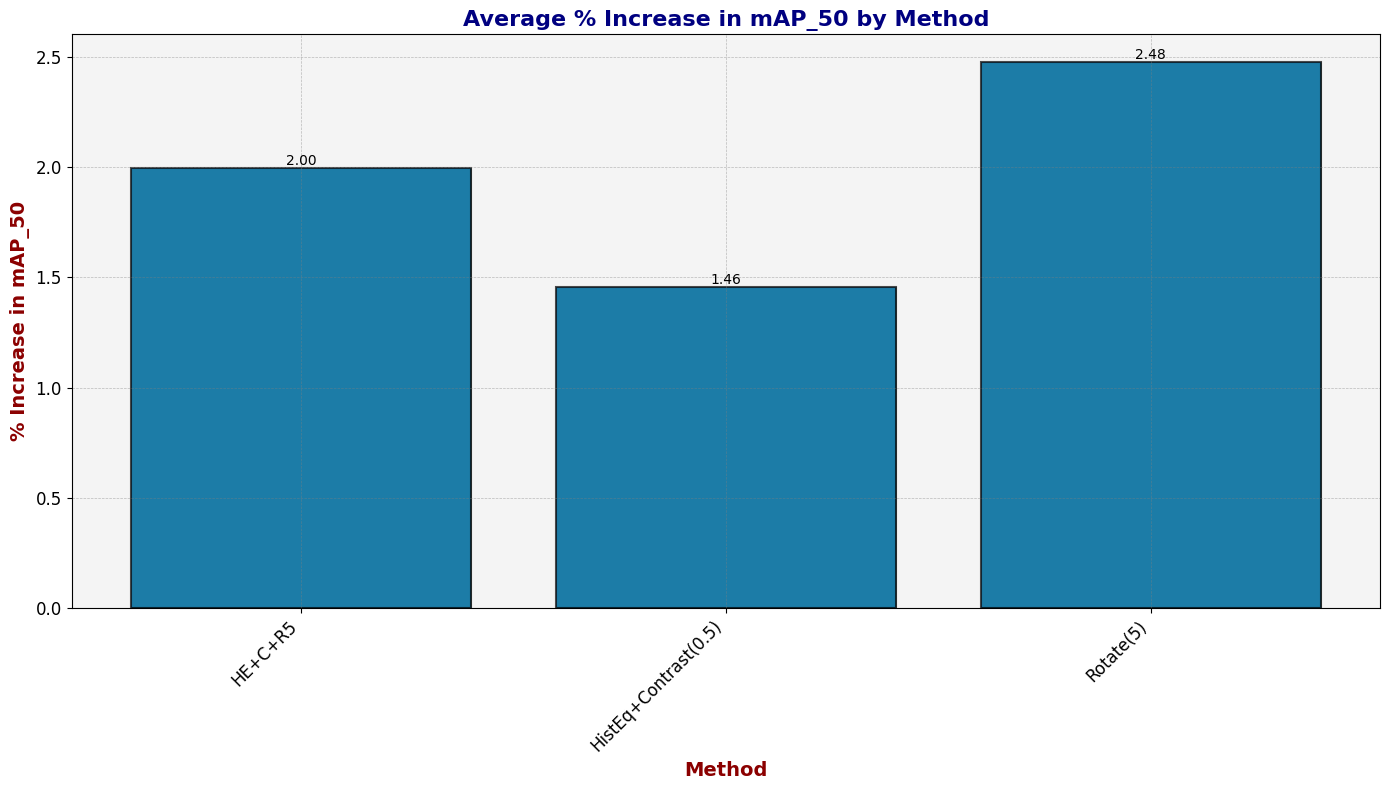

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

path = "../results/round11/percent_increase11.csv"

# Load data
df = pd.read_csv(path)
print(df.columns)


method = 'mAP_50'
method_path = 'map50'

# Simple plot example: Average % increase in AUC for each method
means = df.groupby('method')[f'{method_path}'].mean()


figures_path = "../results/round11/figures/" 

# Styling
plt.figure(figsize=(14, 8))  # Adjust the figure size for better fit and visibility
plt.bar(means.index, means.values, color='teal', width=0.8, edgecolor='grey', linewidth=0.6, alpha=0.9)

# Adding rounded corners to bars
for bar in plt.bar(means.index, means.values):
    bar.set_edgecolor("k") # Black edges
    bar.set_linewidth(1.5)
    bar.set_alpha(0.7)  # Slight transparency

# Background and grid
plt.gca().set_facecolor('#f4f4f4')  # Light grey background
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Titles and labels with enhanced fonts
plt.title(f'Average % Increase in {method} by Method', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Method', fontsize=14, fontweight='bold', color='darkred')
plt.ylabel(f'% Increase in {method}', fontsize=14, fontweight='bold', color='darkred')

# Ticks and tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Text labels above bars
for index, value in enumerate(means):
    plt.text(index, value if value >= 0 else 0, f'{value:.2f}', ha='center', va='bottom' if value > 0 else 'top', fontsize=10, color='black')

plt.tight_layout()  # Adjust layout
plt.savefig(figures_path + f'average_increase_{method_path}.png')  # Save the figure to a file     
plt.show()


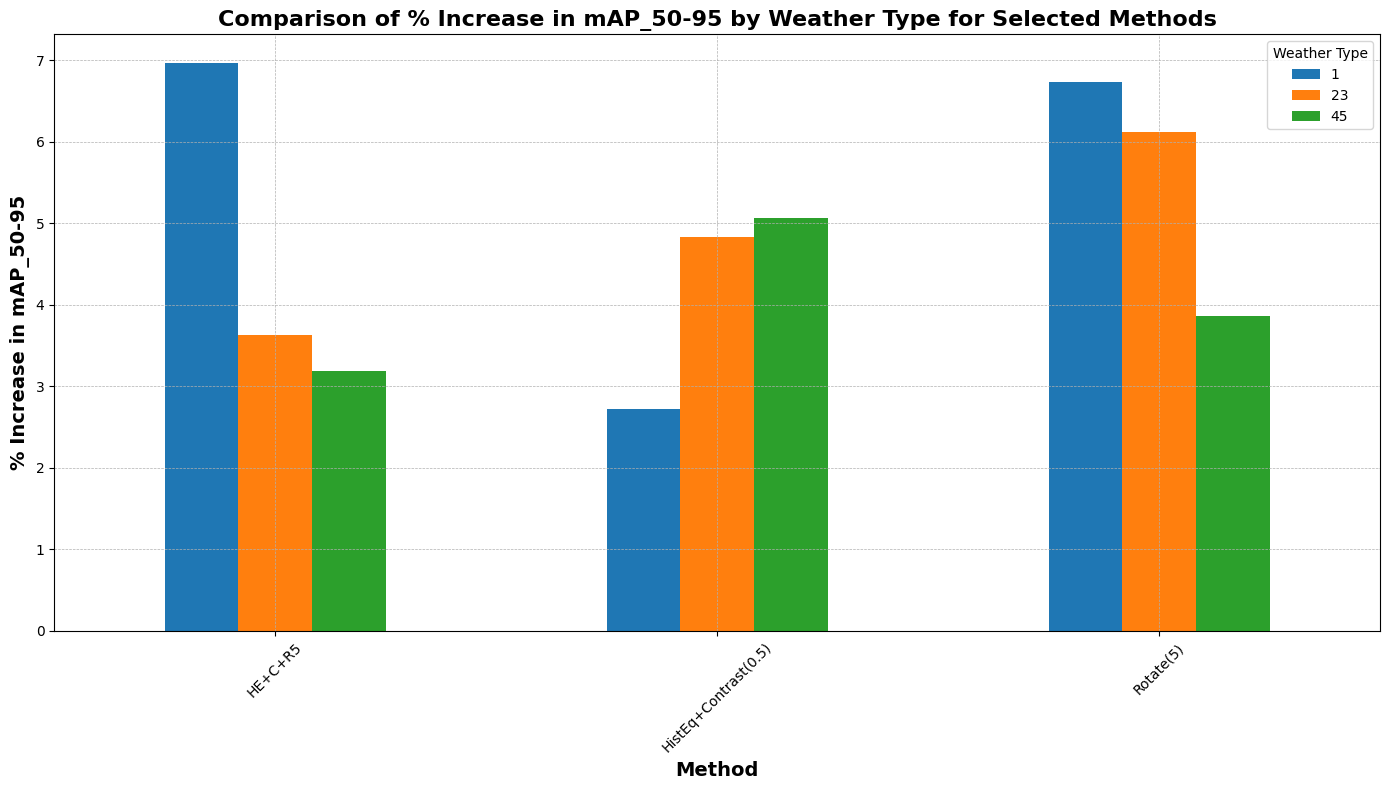

In [78]:
method = 'mAP_50-95'
method_path = 'map50-95'

# Filter for selected methods
selected_methods = ['rotate(5)', 'rotate(20)', 'histeq', 'contrast(0.5)', 'guassian(1050)', 'gaussian(100200)']

# selected methods with all methods
selected_methods = df['method'].unique()

filtered_df = df[df['method'].isin(selected_methods)]


# Pivot data to get % increases for each weather type per method
pivot_df = filtered_df.pivot_table(index='method', columns='weather', values=f'{method_path}', aggfunc='mean')

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
pivot_df.plot(kind='bar', ax=ax)

# Styling
ax.set_title(f'Comparison of % Increase in {method} by Weather Type for Selected Methods', fontsize=16, fontweight='bold')
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel(f'% Increase in {method}', fontsize=14, fontweight='bold')
ax.grid(True, which='major', linestyle='--', linewidth=0.5)
ax.legend(title='Weather Type')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(figures_path + f'comparison_increase_{method}_weather.png')
plt.show()

Index(['method', 'weather', 'map50', 'map50-95', 'f1', 'f1_class1',
       'f1_class2', 'f1_class3'],
      dtype='object')


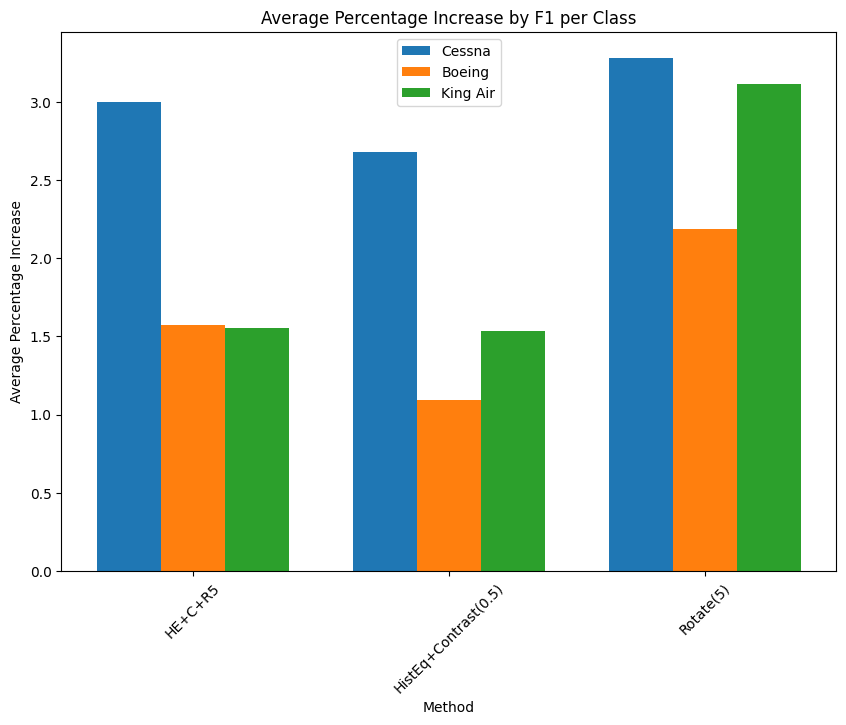

In [79]:
# Group by 'method' and calculate the mean for each group
print(df.columns)


grouped_df = df.groupby('method').mean()


# Plotting
fig, ax = plt.subplots(figsize=(10, 7))

# Width of a bar
bar_width = 0.25

# Index for the groups
index = range(len(grouped_df))

# Plot each F1 class
bar1 = ax.bar(index, grouped_df['f1_class1'], bar_width, label='Cessna')
bar2 = ax.bar([p + bar_width for p in index], grouped_df['f1_class2'], bar_width, label='Boeing')
bar3 = ax.bar([p + bar_width * 2 for p in index], grouped_df['f1_class3'], bar_width, label='King Air')

# Add some details
ax.set_xlabel('Method')
ax.set_ylabel('Average Percentage Increase')
ax.set_title('Average Percentage Increase by F1 per Class')
ax.set_xticks([p + bar_width for p in index])
ax.set_xticklabels(grouped_df.index)
ax.legend()



# Display the plot
plt.xticks(rotation=45)
plt.savefig(figures_path + f'increase_f1_per_class.png')

plt.show()